In [1]:
#% matplotlib inline

from datetime import datetime 
import h5py
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
cmap = cm.get_cmap('Blues')
import random
from scipy import signal, cluster, stats
from multiprocessing import Pool
import scipy as sp
from scipy import linalg
import cairosvg
from PIL import Image

In [2]:
def get_shifted_spline_frame(field, num):
    #get data
    pix_id = (NoiseSplineAlignment() & field).fetch('center_pixel_id')
    shifted_filters =  (NoiseSplineAlignment() & field).fetch('shifted_filter')
    z_position = (NoiseSplineRoiPosition() & field).fetch('z_position')
    x_position = (NoiseSplineRoiPosition() & field).fetch('x_position')
    depth = (NoiseSplineRoiPosition() & field).fetch('depth')

    
    #make frame
    data = pd.DataFrame({'center_pixel_id':pix_id, 'shifted_filters':shifted_filters, 
                         'z_position':z_position, 'x_position':x_position, 'depth':depth,})
    
    
    data['field'] = np.ones(data.shape[0])*num
    data = data.set_index('center_pixel_id')
    return data

# Get original data to create features by cluster

In [3]:
#pull these from hdf5
s_df3 = pd.read_hdf('Data/Fig4.hdf5', 's_df3')
s_df6 = pd.read_hdf('Data/Fig4.hdf5', 's_df6')
s_df7 = pd.read_hdf('Data/Fig4.hdf5', 's_df7')
s_df13 = pd.read_hdf('Data/Fig4.hdf5', 's_df13')


In [4]:
s_df_xz = pd.concat([s_df3, s_df6, s_df7, s_df13])

In [5]:
#flattening
splines = np.asarray(s_df_xz['shifted_filters'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 212*7))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[50:-50,12:19] #fixing this to deal with the stimulator delay
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [6]:
#flattening the other way too
splines = np.asarray(s_df_xz['shifted_filters'])

spline_array_orderC = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten()#order='F')
    spline_array_orderC[i,:] = current_spline_flat

# spline_array_cropped = spline_array[:, 2550:4200]##spline_array[:, 300:-300]

In [7]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

threshold = 2.5
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

s_df_xz_masked = s_df_xz.iloc[quality_mask].copy()

In [8]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/Fig4.hdf5", "r")

#get the data for plotting the sd image
cluster_assignments = np.array(f1['cluster_assignments_original'])
f1.close()

s_df_xz_masked['new_cluster_assignment'] = cluster_assignments

# Get the new data and sparsify

In [9]:
def check_for_duplicates(field):
    center_px, roi_listed = (NoiseSplineROIs() & field).fetch('center_pixel_id', 'pixel_list')

    new_roi_list = []
    unique_center_pixels = []
    duplicates = []
    center_roi_duplicates = []
    

    for roi, roi_list in enumerate(roi_listed):
        roi_list.sort()
        if roi_list not in new_roi_list:
            new_roi_list.append(roi_list)
            unique_center_pixels.append(center_px[roi])
        else:
            duplicates.append(roi_list)
            center_roi_duplicates.append(center_px[roi])
    n_dups = len(center_roi_duplicates)

    return unique_center_pixels, n_dups

In [10]:
def get_line(points):
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = lstsq(A, y_coords, rcond=None)[0]
    
    return m, c

In [11]:
def norm(x): 
    # dividing by the norm = turning a RF into unit vector, 
    # not necessary, but for better visualization
    return x / np.linalg.norm(x) 

In [12]:
def get_spline_frame_pharma(field, pharma_field, num):
    #get data
    pix_id = (NoiseSplineRF2() & field).fetch('center_pixel_id')
    sta =  (NoiseSplineRF2() & field).fetch('sta')
    spl =  (NoiseSplineRF2() & field).fetch('spl')
    
    spl_pharma =  (NoiseSplineRF2() & pharma_field).fetch('spl')
    
    
    #make frame
    data = pd.DataFrame({'center_pixel_id':pix_id, 'sta':sta, 'spl':spl, 'drug_spl':spl_pharma})

    #throw out duplicates
    data = data.set_index('center_pixel_id')
    unique_center_pixels, n_dups = check_for_duplicates(field)
    print("number of duplicates: ", n_dups)
    data = data.loc[data.index.intersection(unique_center_pixels)]
    
    ipl_mask = (IplMask & field).fetch1('roi_mask_ipl')
    coordinates = np.zeros((data.shape[0], 3))
    for index, pixel in enumerate(unique_center_pixels):
        idx = np.where(ipl_mask==pixel*-1)
        coordinates[index, 1:] = np.array([idx[1][0], idx[0][0]]) #z, x
        coordinates[index, 0] = pixel

    data['z_position']= coordinates[:,1]
    data['x_position']=coordinates[:,2]
    
    #get line of the gcl and inl
    left, right, thick = (IplRestrictionInfo & field).fetch1('left','right','thick')
    m1, b1 = get_line([(0,left), (ipl_mask.shape[0],right)])

    shift = m1*data['x_position']+b1
    data['depth']=(data['z_position']-shift)/(thick)
    
    data['field'] = np.ones(data.shape[0])*num
    
    #do clustering on the field and assign groups
    splines = np.asarray(data['spl'])
    spline_array = np.zeros((splines.shape[0], splines[0].shape[0]*splines[0].shape[1]))

    for i, spline in enumerate(splines):
        current_spline = spline.flatten()
        spline_array[i,:] = current_spline
        
    spline_array_cropped = spline_array[:, 3000:5500]##spline_array[:, 300:-300]
    
    # clustering
    ZSign = cluster.hierarchy.linkage(spline_array_cropped, 'ward')
    ListLeavesSign = np.flipud(cluster.hierarchy.leaves_list(ZSign))
    TimeTracesSign = np.copy(spline_array)
    TimeTracesOrderedSign = TimeTracesSign[ListLeavesSign]
    
    # flattening
    t_value = 0.05
    criterion = 'distance' #'maxclust'  #
    pixel_assignment = cluster.hierarchy.fcluster(ZSign, t_value, criterion=criterion)
    n_clusters = np.unique(pixel_assignment).shape[0]
    data['cluster_assignment']=pixel_assignment
    print(n_clusters)
    
    #get cluster averages
    clusters = np.unique(np.array(data['cluster_assignment']))

    average_filters = np.zeros((data['spl'].iloc[0].shape[0], data['spl'].iloc[0].shape[1], clusters.shape[0]))

    for i, clust in enumerate(clusters):
        current_frame = data[data['cluster_assignment']==clust]    
        current_mean = current_frame['spl'].mean()
        average_filters[:,:,i] = current_mean
        
    #finding centers of cluster averages
    max_y = np.zeros(average_filters.shape[2])
    max_t = np.zeros(average_filters.shape[2])
    mean_df = data.groupby(['cluster_assignment']).mean()
    std_df = data.groupby(['cluster_assignment']).std()
    for i in range(average_filters.shape[2]):
        current_filter = average_filters[50:-30,:, i]
        index_max = np.unravel_index(np.argmax(current_filter, axis=None), current_filter.shape)
        index_max = np.unravel_index(np.argmax(current_filter, axis=None), current_filter.shape)
        index_min = np.unravel_index(np.argmin(current_filter, axis=None), current_filter.shape)
        index_min = np.unravel_index(np.argmin(current_filter, axis=None), current_filter.shape)
        if mean_df['depth'].iloc[i] > 0.41:
            max_y[i] = index_min[1]
            max_t[i] = index_min[0]+50
        else:
            max_y[i] = index_max[1]
            max_t[i] = index_max[0]+50
    mean_df['max_y'] = max_y
    mean_df['max_t'] = max_t
    
    print(max_y)
#     print(max_y)
    
#     #get ratio of 1st and 2nd svd component to look at S-T separability
#     svd_check = np.zeros(average_filters.shape[2])
#     for i in range(average_filters.shape[2]):
#         u, s, vh = np.linalg.svd(average_filters[50:-30,:,i].T)  # do the svd
#         svd_check[i] = s[1]/s[0]
    
#     mean_df['svd_ratio'] = svd_check
    
    #set up for realignment using the cluster centers
    cluster_center = mean_df['max_y'].loc[data['cluster_assignment']]
    data['cluster_center'] = np.array(cluster_center)
    
    #create the centered spline fits
    new_center = 13
    max_shift = 6
    total_shift = 12
    shifts = data['cluster_center']-new_center
    round_shifts = np.round(shifts)

    shifted_filters = np.zeros((np.int(data['spl'].iloc[0].shape[1]+total_shift), 
                                data['spl'].iloc[0].shape[0], data.shape[0]))
    shifted_filters = np.where(shifted_filters==0, np.nan, shifted_filters)
    print(shifted_filters.shape)
    shifted_filters_drug = np.zeros((np.int(data['drug_spl'].iloc[0].shape[1]+total_shift), 
                                data['drug_spl'].iloc[0].shape[0], data.shape[0]))
    shifted_filters_drug = np.where(shifted_filters==0, np.nan, shifted_filters)
    
    data['shifted_filters']=data['spl']
    data['shifted_filters_drug']=data['drug_spl']

    begin = max_shift
    end = max_shift+data['spl'].iloc[0].shape[1]
    print(begin, end)
    roi_list = data.index
    count = 0
    for i, roi in enumerate(roi_list):
        current_filter = data['spl'].loc[roi]
        current_filter = current_filter/np.linalg.norm(current_filter) #normalizing these
        shift = round_shifts.loc[roi]
        begin_shift = np.int(begin-shift)
        end_shift = np.int(end-shift)
        
        if end_shift > shifted_filters.shape[0]:
            print("cropped ROI ", roi, " shift of ", shift)
            count+=1
            
            fixed_dim = shifted_filters.shape[0]-end_shift
#             print(fixed_dim)
#             print(end_shift, fixed_dim, shifted_filters.shape[0]-1)
            shifted_filters[begin_shift:end_shift,:,i] = current_filter.T[:fixed_dim, :]
            data['shifted_filters'].loc[roi] = shifted_filters[:,:,i].T
        
            #also shift the drug splines in the same way
            current_filter = data['drug_spl'].loc[roi]
            current_filter = current_filter/np.linalg.norm(current_filter) #normalizing these
            shifted_filters_drug[begin_shift:end_shift,:,i] = current_filter.T[:fixed_dim, :]
            data['shifted_filters_drug'].loc[roi] = shifted_filters_drug[:,:,i].T
        else:   
            shifted_filters[begin_shift:end_shift,:,i] = current_filter.T
            data['shifted_filters'].loc[roi] = shifted_filters[:,:,i].T

            #also shift the drug splines in the same way
            current_filter = data['drug_spl'].loc[roi]
            current_filter = current_filter/np.linalg.norm(current_filter) #normalizing these
            shifted_filters_drug[begin_shift:end_shift,:,i] = current_filter.T
            data['shifted_filters_drug'].loc[roi] = shifted_filters_drug[:,:,i].T
    

# mean_shifted_filters = np.nanmean(shifted_filters, axis=2)
    
    print("fixed ", count, " rois in total")
    return data, TimeTracesOrderedSign, average_filters, mean_df, std_df, shifted_filters, shifted_filters_drug
    

In [13]:
def get_roi_sizes(field):
    #get the roi groups and scaling information
    roi_groups = (NoiseSplineROIs() & field).fetch('pixel_list')
    x_zoom = (Presentation.ScanInfo() & field).fetch1('zoom')
    z_zoom = (Presentation.ScanInfo() & field).fetch1('user_zoomz')
    roimask = (Field.RoiMask() & field).fetch1('roi_mask')
    x_dimension = roimask.shape[0]
    z_dimension = roimask.shape[0]
    
    um_pixel_x = (71.5/x_zoom)/x_dimension
    um_pixel_z = (61.6/z_zoom)/z_dimension
    um_pixel_both = np.sqrt(um_pixel_x*um_pixel_z)
    
    #get the diameter of each ROI scaled in microns
    roi_sizes = [np.sqrt(len(x))*um_pixel_both for x in roi_groups]
    print(np.mean(roi_sizes))
    return roi_sizes

In [14]:
# s_df1, ordered_traces1, average_filters1, mean_df1, std_df1, shifted_filters1, shifted_filters_drug1 = get_spline_frame_pharma(
#     field1_c, field1_s, 11)

In [15]:
# s_df2, ordered_traces2, average_filters2, mean_df2, std_df2, shifted_filters2, shifted_filters_drug2 = get_spline_frame_pharma(
#     field2_c, field2_s, 22)

In [16]:
# s_df33, ordered_traces3, average_filters3, mean_df3, std_df3, shifted_filters3, shifted_filters_drug3 = get_spline_frame_pharma(
#     field3_c, field3_s, 33)

In [17]:
# s_df4, ordered_traces4, average_filters4, mean_df4, std_df4, shifted_filters4, shifted_filters_drug4 = get_spline_frame_pharma(
#     field4_c, field4_s, 44)

In [18]:
# s_df5, ordered_traces5, average_filters5, mean_df5, std_df5, shifted_filters5, shifted_filters_drug5 = get_spline_frame_pharma(
#     field5_c, field5_s, 55) 

In [19]:
#pull these from hdf5
s_df1 = pd.read_hdf('Data/FigS08.hdf5', 's_df1')
s_df2 = pd.read_hdf('Data/FigS08.hdf5', 's_df2')
s_df33 = pd.read_hdf('Data/FigS08.hdf5', 's_df33')
s_df4 = pd.read_hdf('Data/FigS08.hdf5', 's_df4')
s_df5 = pd.read_hdf('Data/FigS08.hdf5', 's_df5')


In [20]:
s_df_xz_new = pd.concat([s_df1, s_df2, s_df33, s_df4, s_df5]) #s_df2, not ready yet

In [21]:
#flattening
splines = np.asarray(s_df_xz_new['shifted_filters'])
spline_array = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))
spline_array_cropped = np.zeros((splines.shape[0], 212*7))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten(order='F')
    spline_array[i,:] = current_spline_flat
    
    current_spline_cropped = spline[30:-70,12:19] #cropping the time differently to deal with the stimulator delay!!
    current_spline_cropped_flat = current_spline_cropped.flatten()#order='F'
    spline_array_cropped[i,:] = current_spline_cropped_flat

In [22]:
#flattening the other way too
splines = np.asarray(s_df_xz_new['shifted_filters'])

spline_array_orderC = np.zeros((splines.shape[0], (splines[0].shape[0])*splines[0].shape[1]))

for i, spline in enumerate(splines):
    current_spline = spline
    current_spline_flat = current_spline.flatten()#order='F')
    spline_array_orderC[i,:] = current_spline_flat

In [23]:
zscored_spline_array = ((spline_array_cropped.T-np.mean(spline_array_cropped, axis=1))/np.std(spline_array_cropped, axis=1)).T

threshold = 2.5
quality_mask = np.where(np.amax(np.abs(zscored_spline_array), axis=1)>threshold)

s_df_xz_new_masked = s_df_xz_new.iloc[quality_mask].copy()

# Clustering

In [24]:
#pull from hdf5 file
#read hdf5 file for this notebook
f1 = h5py.File("Data/FigS08.hdf5", "r")

#get the data
cluster_assignments = np.array(f1['cluster_assignments'])
f1.close()

s_df_xz_new_masked['new_cluster_assignment'] = cluster_assignments

# Clustering Results

In [25]:
s_df_xz_copy = s_df_xz_new_masked.copy(deep=True)
s_df_xz_copy = s_df_xz_copy.set_index(['new_cluster_assignment'])

cluster_avg_depth = s_df_xz_copy['depth'].groupby(['new_cluster_assignment']).mean()

cluster_avg_depth

new_cluster_assignment
0     0.017993
1     0.676268
2     0.363811
3     0.139047
4     0.887724
5     0.558538
6     0.673275
7     0.214788
8     0.467885
9     0.121460
10    0.724199
11    0.365152
12    0.833853
Name: depth, dtype: float64

In [26]:
#from original clustering
ipl_depth_order = np.array([0, 3, 9, 7, 11, 2, 8, 5, 6, 1, 10, 12, 4])

/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 32.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 25.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs01/euler/User/avlas

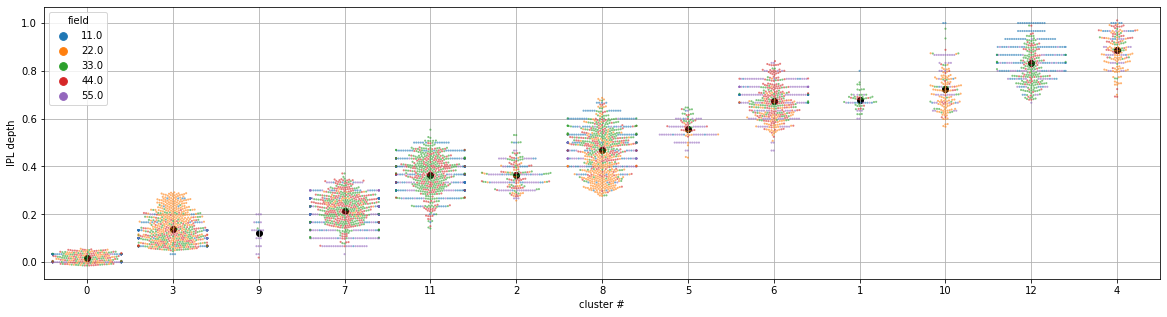

In [27]:
#plot clusters by IPL depth
n_bins = 10
current_palette = sns.color_palette()

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, current_palette, N=n_bins)

c = s_df_xz_new_masked['field']

fig=plt.figure(figsize=(20,5))


ax = sns.swarmplot(data=s_df_xz_new_masked, x="new_cluster_assignment", y="depth", hue="field",
                   alpha=0.6, cmap='cm', size=2.1, order=ipl_depth_order) #color='k', 
# plt.scatter(s_df_xz['new_cluster_assignment'], s_df_xz['depth'], alpha=0.3, c=c, cmap=cm)
# plt.colorbar()
plt.scatter(cluster_avg_depth.index, cluster_avg_depth[ipl_depth_order], color='k')

axes = plt.gca()
# axes.axhline(on_top, linestyle='dotted', color='k')
# axes.axhline(on_bottom, linestyle='dotted', color='k')
# axes.axhline(on_mean, linestyle='dotted', color='k')
# axes.axhline(off_top, linestyle='dotted', color='k')
# axes.axhline(off_bottom, linestyle='dotted', color='k')
# axes.axhline(off_mean, linestyle='dotted', color='k')
axes.set_xlabel('cluster #')
axes.set_ylabel('IPL depth')
plt.grid(True)

# Figpath = 'Fig_temp/'
# savename = Figpath+"Clusters_ipl_depth_chat.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

# insert the cluster assignments into the database

# combine for analysis

In [28]:
#make combined df for doing the averages
s_df_xz_new_masked['shifted_filters_corrected'] = s_df_xz_new_masked['shifted_filters'].apply(lambda x: x[:-40,:])
s_df_xz_new_masked['shifted_filters_corrected_drug'] = s_df_xz_new_masked['shifted_filters_drug'].apply(lambda x: x[:-40,:])

s_df_xz_masked['shifted_filters_corrected'] = s_df_xz_masked['shifted_filters'].apply(lambda x: x[40:,:])

allroi_df = pd.concat([s_df_xz_new_masked, s_df_xz_masked])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


In [29]:
#make average filters
clusters = np.unique(np.array(allroi_df['new_cluster_assignment']))

average_filters = np.zeros((allroi_df['shifted_filters_corrected'].iloc[0].shape[0], allroi_df['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))
average_filters_drug = np.zeros((s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[0], s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))

for i, clust in enumerate(clusters):
    current_frame = allroi_df[allroi_df['new_cluster_assignment']==clust]    
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters_corrected']), axis=2)
    average_filters[:,:,i] = current_mean
    
    current_frame = s_df_xz_new_masked[s_df_xz_new_masked['new_cluster_assignment']==clust]
    current_mean = np.nanmean(np.dstack(current_frame['shifted_filters_corrected_drug']), axis=2)
    average_filters_drug[:,:,i] = current_mean
    

#make SD of filters
clusters = np.unique(np.array(allroi_df['new_cluster_assignment']))

sd_filters = np.zeros((allroi_df['shifted_filters_corrected'].iloc[0].shape[0], allroi_df['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))
sd_filters_drug = np.zeros((
    s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[0], s_df_xz_new_masked['shifted_filters_corrected'].iloc[0].shape[1], clusters.shape[0]))


for i, clust in enumerate(clusters):
    current_frame = allroi_df[allroi_df['new_cluster_assignment']==clust]    
    current_sd = np.nanstd(np.dstack(current_frame['shifted_filters_corrected']), axis=2)
    sd_filters[:,:,i] = current_sd
    
    current_frame = s_df_xz_new_masked[s_df_xz_new_masked['new_cluster_assignment']==clust]
    current_sd = np.nanstd(np.dstack(current_frame['shifted_filters_corrected_drug']), axis=2)
    sd_filters_drug[:,:,i] = current_sd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


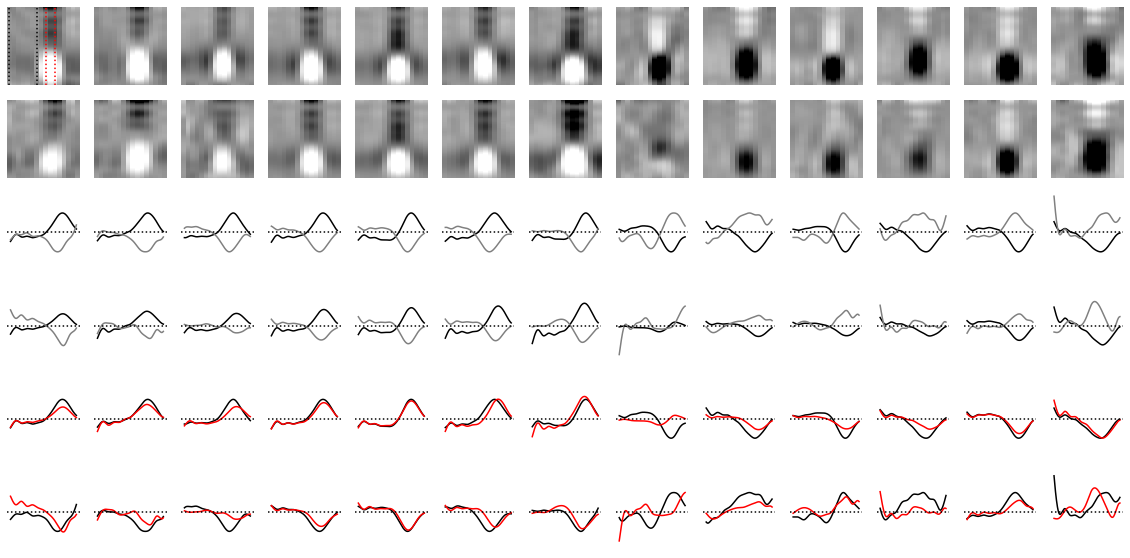

In [30]:
#plot the cluster averages and normalized temporal kernels and calculate latency and surround strength

polarity = [1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, 1, -1]
latency = np.zeros(len(polarity))
surround_strength = np.zeros(len(polarity))

latency_drug = np.zeros(len(polarity))
surround_strength_drug = np.zeros(len(polarity))

center_change_index = np.zeros(len(polarity))
surround_change_index =  np.zeros(len(polarity))

maxmin = 0.06
plot_range = 2

fig, ax = plt.subplots(6, 13, figsize=(20, 10))
for i, clust in enumerate(ipl_depth_order):
    
#     ax[0, i].imshow(spline_array[quality_mask[0],:][s_df_xz_masked['new_cluster_assignment']==clust], aspect=12, cmap='Greys_r')
#     ax[0, i].set_yticklabels([])
#     ax[0, i].set_xticklabels([])
#     ax[0, i].axis('off')
    
    ax[0, i].imshow(average_filters[:,10:26,clust]/np.linalg.norm(average_filters[:,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-maxmin, vmax=maxmin)
    if i == 0:
        ax[0, i].axvline(10-10, color='k', linestyle='dotted')
        ax[0, i].axvline(16-10, color='k', linestyle='dotted')
        ax[0, i].axvline(18-10, color='r', linestyle='dotted')
        ax[0, i].axvline(20-10, color='r', linestyle='dotted')
    ax[0, i].axis('off')
    
    ax[1, i].imshow(average_filters_drug[:,10:26,clust]/np.linalg.norm(average_filters[:,11:19,clust]), 
                    aspect='auto', cmap='Greys_r', vmin=-maxmin, vmax=maxmin)
    
    ax[1, i].axis('off')

    
    
    avg_filter_flipped = average_filters[:,:,clust]*polarity[clust] #deal with off cells

    ax[2, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='k',)
    ax[2, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[2, i].axhline(color='k', linestyle='dotted')
    ax[2, i].set_yticklabels([])
    ax[2, i].set_xticklabels([])
    ax[2, i].axis('off')
    ax[2, i].set_ylim([-plot_range,plot_range])
    
    
    avg_filter_flipped_drug = average_filters_drug[:,:,clust]*polarity[clust] #deal with off cells

    ax[3, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='k',)
    ax[3, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='grey')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[3, i].axhline(color='k', linestyle='dotted')
    ax[3, i].set_yticklabels([])
    ax[3, i].set_xticklabels([])
    ax[3, i].axis('off')
    ax[3, i].set_ylim([-plot_range,plot_range])
    
    
    ax[4, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='k',)
    ax[4, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[50:,18:21], axis=1)), color='r',)
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[4, i].axhline(color='k', linestyle='dotted')
    ax[4, i].set_yticklabels([])
    ax[4, i].set_xticklabels([])
    ax[4, i].axis('off')
    ax[4, i].set_ylim([-plot_range,plot_range])
    
    ax[5, i].plot(polarity[clust]*np.mean(avg_filter_flipped[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='k')
    ax[5, i].plot(polarity[clust]*np.mean(avg_filter_flipped_drug[:,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:,10:17], axis=1))*-1, color='r')
#     ax[2].plot(np.mean(avg_filter_flipped[:,22:26], axis=1)/np.amin(np.mean(avg_filter_flipped[100:290,22:26], axis=1))*-1, color='b')
    ax[5, i].axhline(color='k', linestyle='dotted')
    ax[5, i].set_yticklabels([])
    ax[5, i].set_xticklabels([])
    ax[5, i].axis('off')
    ax[5, i].set_ylim([-plot_range,plot_range])
    
#     Figpath = 'Fig_temp/'
#     savename = Figpath+"Cluster_avgs_"+str(i)+".pdf"
#     plt.savefig(savename, transparent=True, bbox_inches='tight')

#     plt.show()
    center = np.mean(avg_filter_flipped[100:230,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:230,18:21], axis=1))
    surround = np.mean(avg_filter_flipped[100:230,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:230,10:17], axis=1))
    
    center_drug = np.mean(avg_filter_flipped_drug[100:230,18:21], axis=1)/np.amax(np.mean(avg_filter_flipped[100:230,18:21], axis=1))
    surround_drug = np.mean(avg_filter_flipped_drug[100:230,10:17], axis=1)/np.amin(np.mean(avg_filter_flipped[100:230,10:17], axis=1))
    
    latency[clust] = np.argmax(center)-np.argmax(surround) 
    surround_strength[clust] = np.amin(np.mean(avg_filter_flipped[50:230,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped[50:230,18:21], axis=1))

    latency_drug[clust] = np.argmax(center_drug)-np.argmax(surround_drug) 
    surround_strength_drug[clust] = np.amin(np.mean(avg_filter_flipped_drug[50:230,10:17], axis=1))/np.amax(np.mean(avg_filter_flipped_drug[50:230,18:21], axis=1))

    center_change_index[clust] = (np.amax(center) - np.amax(center_drug))/np.amax(center)
    surround_change_index[clust] = (np.amax(surround) - np.amax(surround_drug))/np.amax(surround)
    
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"Cluster_avgs_strychnine.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()
    

In [31]:
from scipy.optimize import curve_fit

def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

0 72.669115392265
1 61.38351200750019
2 69.54751629203973
3 67.617518535442
4 75.9473279784847
5 63.772388969130624
6 76.73014578909172
7 67.79402054876283
8 71.23241206997271
9 60.61991896419337
10 73.9043806938102
11 65.81280613976618
12 72.9465262433278


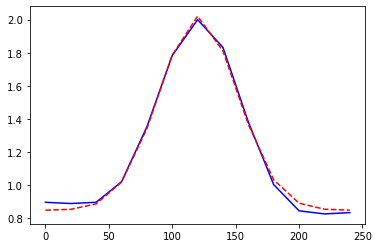

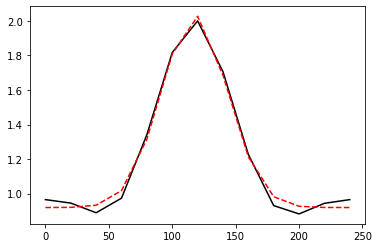

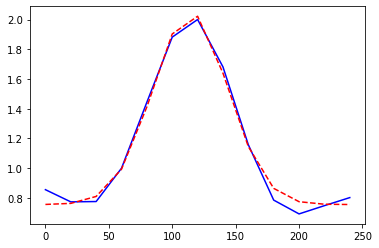

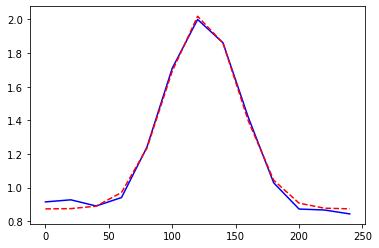

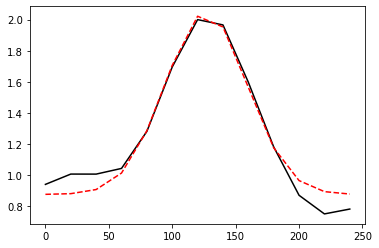

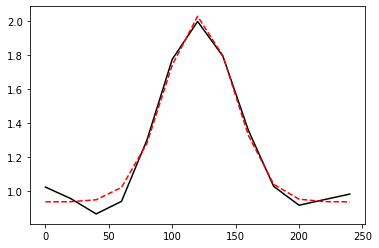

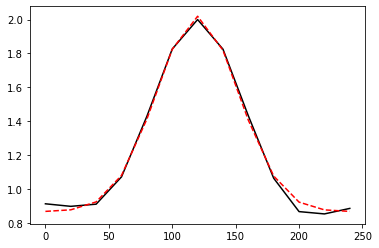

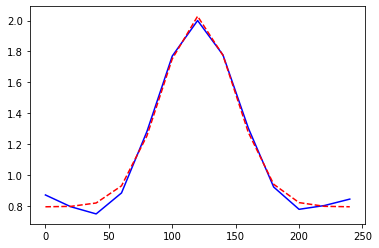

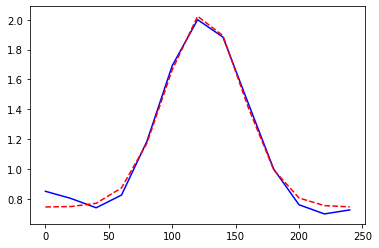

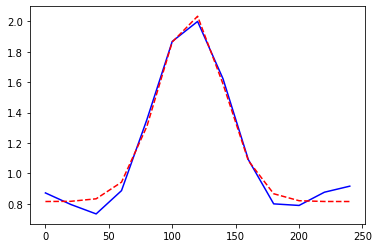

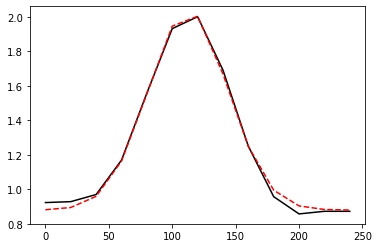

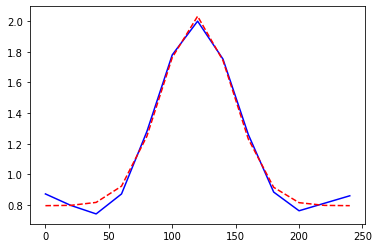

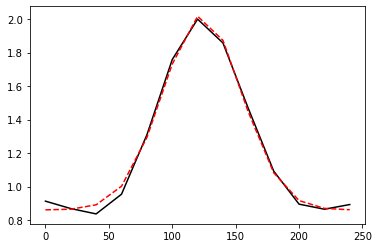

In [32]:
#calculate center FWHM by doing Gaussian Fit

center_fwhm=np.zeros(clusters.shape[0])
colors_polarity = ['black', 'red', 'blue']
for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters[200:220,13:26,i], axis=0)*polarity[i]
    space_positions = np.arange(mean_filter.shape[0])*20 #in microns
    
    
    fig = plt.figure()
    plt.plot(space_positions, mean_filter/np.amax(mean_filter)+1, color=colors_polarity[polarity[i]+1])
    

    
    H, A, x0, sigma = gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1) #adding one to get the algorithm to behave
    FWHM = 2.35482 * sigma
    center_fwhm[i] = FWHM
    print(i, FWHM)
    plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1)), '--r', label='fit')

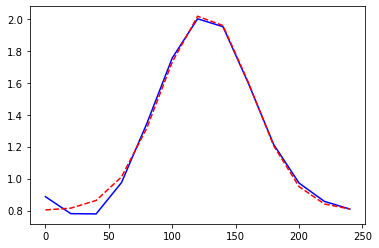

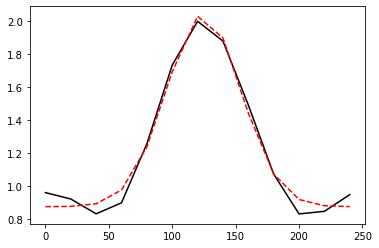

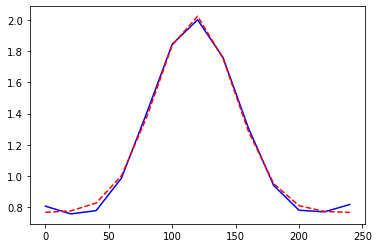

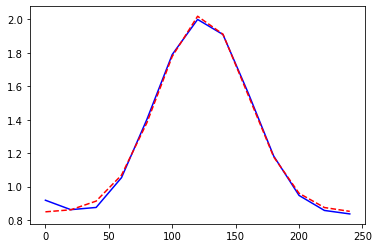

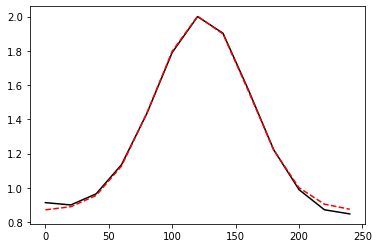

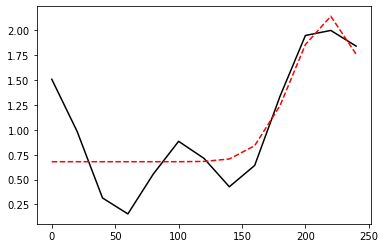

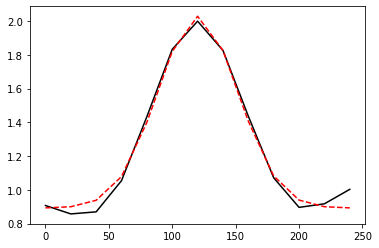

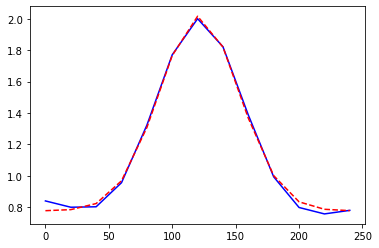

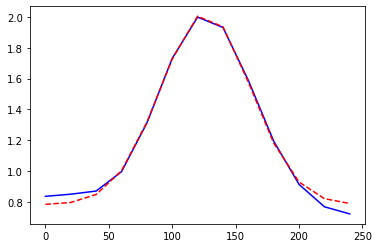

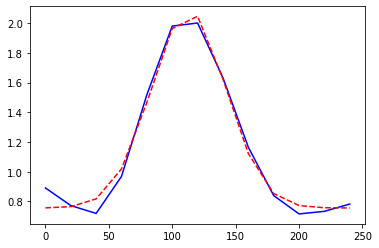

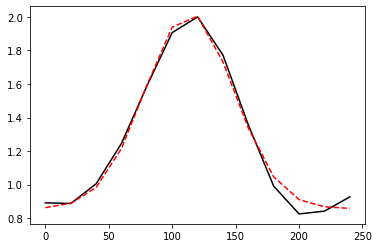

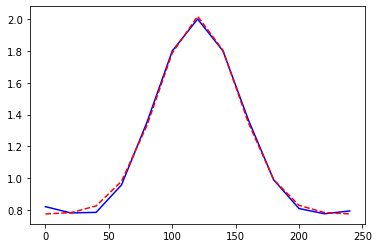

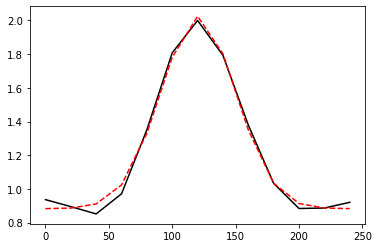

In [33]:
#calculate center FWHM by doing Gaussian Fit

center_fwhm_drug=np.zeros(clusters.shape[0])
colors_polarity = ['black', 'red', 'blue']
for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters_drug[200:220,13:26,i], axis=0)*polarity[i] #correcting for stimulator delay
    space_positions = np.arange(mean_filter.shape[0])*20 #in microns
    
    
    fig = plt.figure()
    plt.plot(space_positions, mean_filter/np.amax(mean_filter)+1, color=colors_polarity[polarity[i]+1])
    

    
    H, A, x0, sigma = gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1) #adding one to get the algorithm to behave
    FWHM = 2.35482 * sigma
    center_fwhm_drug[i] = FWHM
    
    plt.plot(space_positions, gauss(space_positions, *gauss_fit(space_positions, mean_filter/np.amax(mean_filter)+1)), '--r', label='fit')

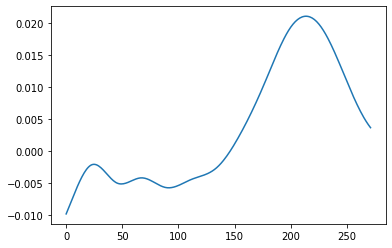

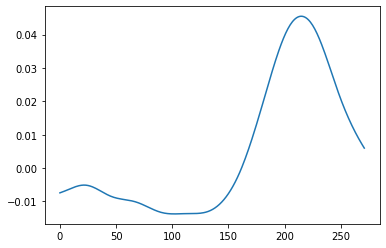

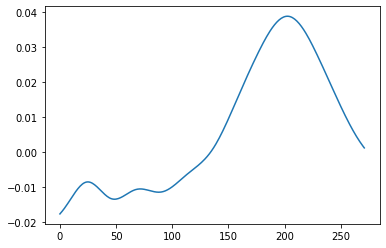

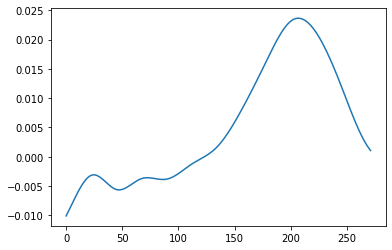

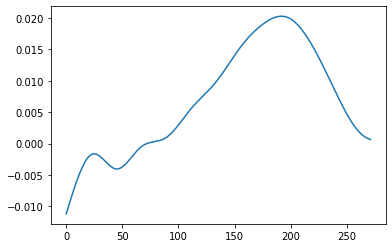

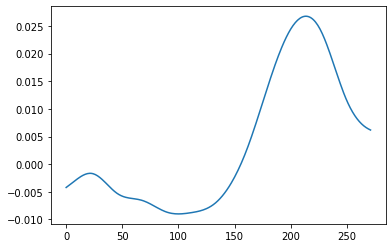

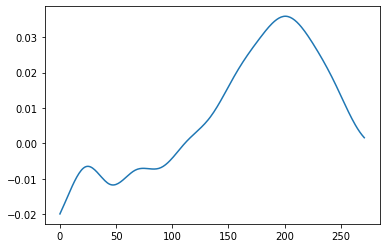

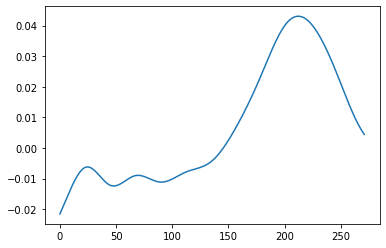

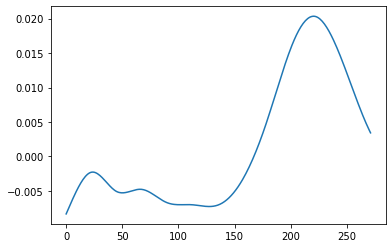

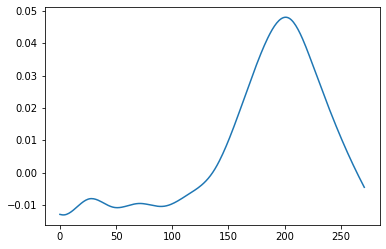

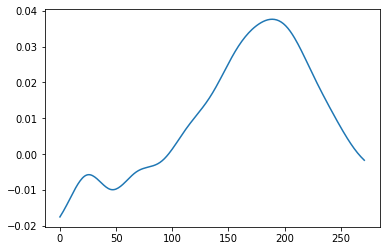

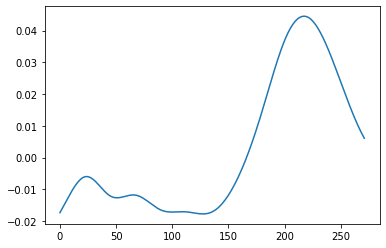

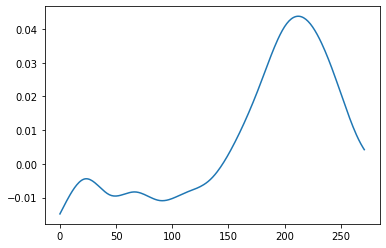

In [34]:
#calculate biphasic index

center_biphasic_index=np.zeros(clusters.shape[0])

for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters[:,18:21,i], axis=1)*polarity[i]
    
    fig = plt.figure()
    plt.plot(mean_filter)
    
    filter_max = np.amax(mean_filter)
    filter_min = np.amin(mean_filter[50:200])
    biphasic_index = filter_min/filter_max*-1
    center_biphasic_index[i] = biphasic_index

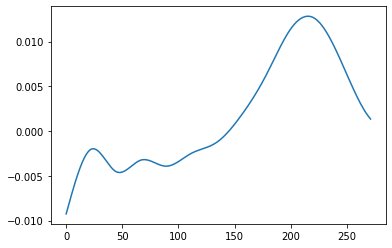

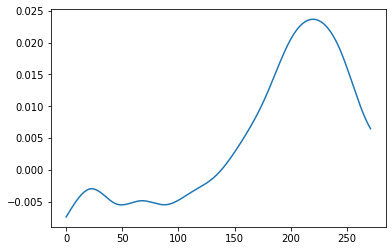

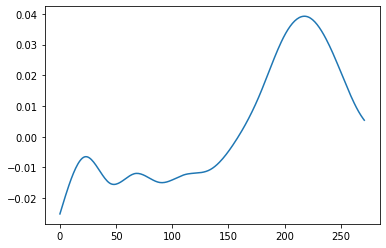

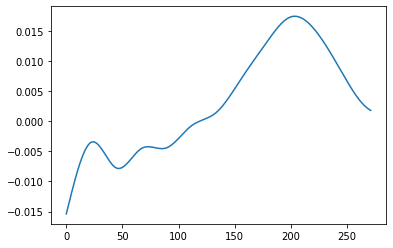

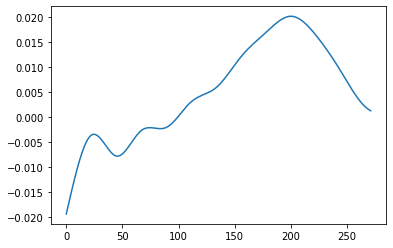

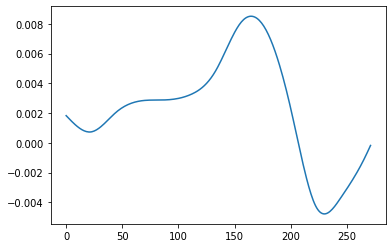

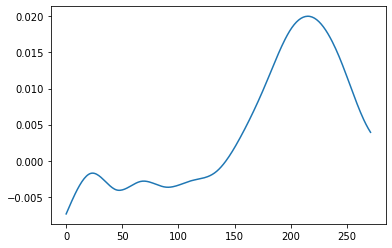

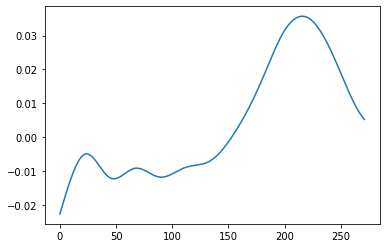

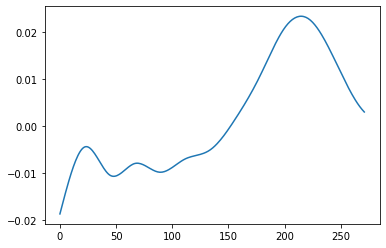

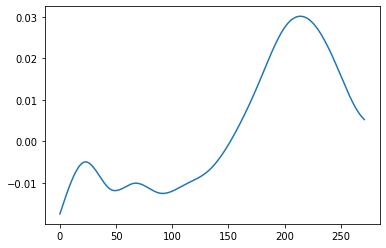

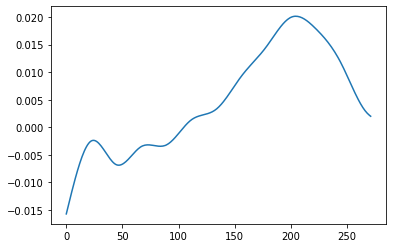

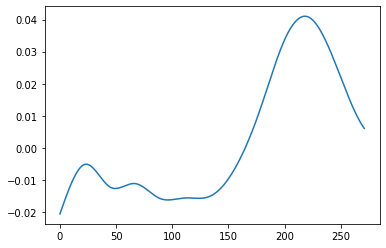

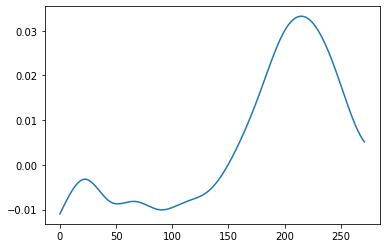

In [35]:
#calculate biphasic index

center_biphasic_index_drug=np.zeros(clusters.shape[0])

for i in range(clusters.shape[0]):
    mean_filter = np.mean(average_filters_drug[:,18:21,i], axis=1)*polarity[i]
    
    fig = plt.figure()
    plt.plot(mean_filter)
    
    filter_max = np.amax(mean_filter)
    filter_min = np.amin(mean_filter[50:200])
    biphasic_index = filter_min/filter_max*-1
    center_biphasic_index_drug[i] = biphasic_index

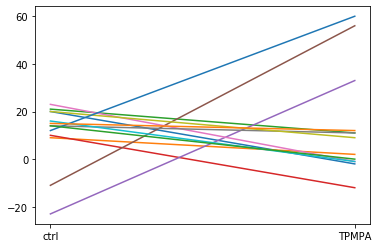

In [36]:
for i in range(13):
    plt.plot(['ctrl','TPMPA'], [latency[i], latency_drug[i]])

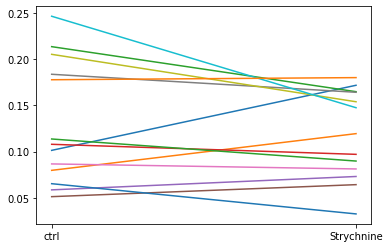

In [37]:
for i in range(13):
    plt.plot(['ctrl','Strychnine'], [surround_strength[i]*-1, surround_strength_drug[i]*-1])

(-0.15, 1.15)

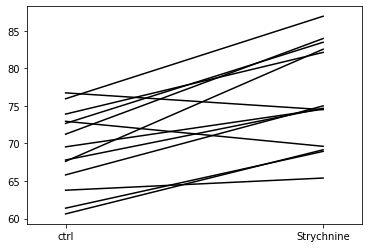

In [38]:
for i in range(13):
    plt.plot(['ctrl','Strychnine'], [abs(center_fwhm[i]), abs(center_fwhm_drug[i])], c='k')
    
axes=plt.gca()
axes.set_xlim([-.15,1.15])
    
# Figpath = 'Fig_temp/'
# savename = Figpath+"FWHM_control_strychnine.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

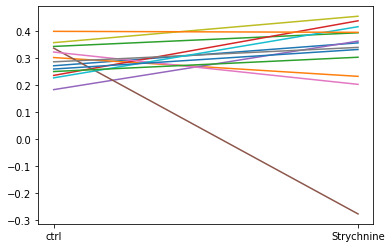

In [39]:
for i in range(13):
    plt.plot(['ctrl','Strychnine'], [center_biphasic_index[i], center_biphasic_index_drug[i]])

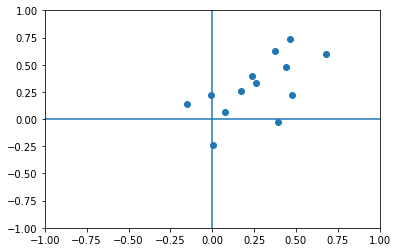

In [40]:
plt.scatter(center_change_index, surround_change_index)
axes = plt.gca()
axes.set_ylim([-1,1])
axes.set_xlim([-1,1])
axes.axhline(0)
axes.axvline(0)

In [41]:
def get_svg_parameters_on_screen(dendrite_length, moving_bar_length, stimulus_velocity,
                             starting_point, distance_covered, real_time_lag, time_points, space_per_pixel):
    temporal_conversion = time_points / real_time_lag  # From seconds to pixel.
    spatial_conversion = 1 / space_per_pixel  # From um to pixel.

    # Moving bar is already fully on screen at t = 0
    distance_moved = distance_covered - moving_bar_length  # [um]
    stimulation_time = (distance_moved / stimulus_velocity)  # [s]

    # Convert from seconds & um to pixel
    stimulation_time_pixel = stimulation_time * temporal_conversion

    distance_moved_pixel = distance_moved * spatial_conversion
    dendrite_length_pixel = dendrite_length * spatial_conversion
    moving_bar_length_pixel = moving_bar_length * spatial_conversion
    starting_point_pixel = starting_point * spatial_conversion
    distance_covered_pixel = distance_covered * spatial_conversion

    # Slope of diagonal
    slope = -stimulation_time_pixel / distance_moved_pixel

    # Calculate thickness of diagonal
    alpha = np.arctan(stimulation_time_pixel / distance_moved_pixel)
    diagonal_thickness = moving_bar_length_pixel * np.sin(alpha)

    # Calculate coordinates for beginning & end of diagonal
    # Diagonal starts and ends out of picture to allow for a smooth & exact picture.
    x_start = starting_point_pixel
    x_stop = x_start + distance_covered_pixel

    y_start = (moving_bar_length_pixel / 2) * slope  # Negative
    y_stop = stimulation_time_pixel - y_start

    return (stimulation_time_pixel, dendrite_length_pixel,
            diagonal_thickness,
            x_start, x_stop, y_start, y_stop)

In [42]:
#pull the convolution parameters for modeling
convolution_params = {}
file = h5py.File('Data/Fig5.hdf5', 'r')
dict_group_load = file['convolution_params']
dict_group_keys = dict_group_load.keys()
for k in dict_group_keys:
    convolution_params[k]= np.float(dict_group_load[k][0])
    
real_time_lag = convolution_params['real_time_lag']
time_points = convolution_params['time_points']
space_per_pixelx = convolution_params['space_per_pixelx']
space_per_pixely = convolution_params['space_per_pixely']
file.close()

array([-0.03443281, -0.00679397, -0.14377462, -0.05103353,  0.01832009,
        0.00695351, -0.03237312, -0.18226003, -0.27477748, -0.1972912 ,
       -0.0391588 , -0.18723202, -0.10174225])

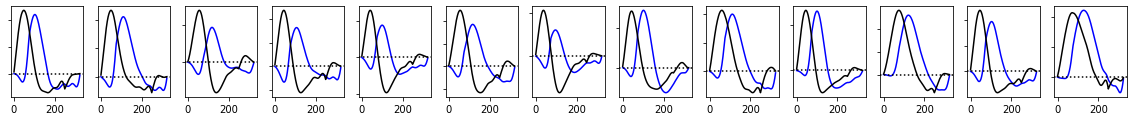

In [43]:
# Get response predictions for 1000 um/s for display

# get the stimulus for convolution

convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140
if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))

#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters[:,:,clust]
    edge_buffer = 1 #changing to at least partially correct for the 
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'
    
    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-(edge_buffer+20), :] #correcting for time offset
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')


dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
dsi_all
# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_half.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

array([-0.09827108, -0.02291052, -0.1352631 , -0.00183421, -0.14403772,
        0.09831501, -0.02989986, -0.11819533, -0.09414848, -0.13973124,
       -0.01065961, -0.13226346, -0.01778581])

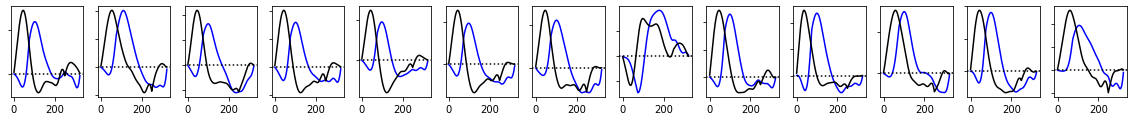

In [44]:
# Get response predictions for 1000 um/s for display drug

# get the stimulus for convolution

convolution_params['stimulus_velocity'] = 1000 # WARNING altering this to play around with velocity tuning
convolution_params['dendrite_length'] = 140
convolution_params['distance_covered'] = 140

if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
    space_per_pixel = space_per_pixelx
else:
    space_per_pixel = space_per_pixely

time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
    convolution_params['dendrite_length'],
    convolution_params['moving_bar_length'],
    convolution_params['stimulus_velocity'],
    convolution_params['starting_point'],
    convolution_params['distance_covered'],
    real_time_lag,
    time_points,
    space_per_pixel
)

string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
    <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
      <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
          stroke-width="{10}" stroke="white" stroke-linecap="square"/>
    </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

folder_str = 'Data/'
file_name = str(1)
name_svg = folder_str + file_name + ".svg"
name_png = folder_str + file_name + ".png"

new_file = open(name_svg, "wt")
new_file.write(string_svg)
new_file.close()

cairosvg.svg2png(url=name_svg, write_to=name_png)

stimulus_image = np.array(Image.open(name_png).convert('L'))



#get convolved responses

# cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
dsi = np.zeros(13)
dsi_off = np.zeros(13)

fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):
    # get the necessaries
    # spline = (NoiseSplineRF2 & key).fetch1('spl')
    spline = average_filters_drug[:,:,clust]
    edge_buffer = 1 #
    stimulus_image_rev = np.flip(stimulus_image, axis=0)
    kernel_type = 'left'

    # set up and crop the kernel
    kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

    # get the location of the RF center in the kernel
    spline_temp = spline[edge_buffer:-(edge_buffer+20), :]
    index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
    peak_y = index_max[1]
    peak_y = 19

    # crop the kernel depending on the type of experiment
    if kernel_type == 'right':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
    elif kernel_type == 'left':
        spline_cut = spline[edge_buffer:-(edge_buffer+20), np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
    elif kernel_type == 'full':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     0:kernel_length]  # should be full kernel, just adding space range just in case
    elif kernel_type == 'centered':
        spline_cut = spline[edge_buffer:-(edge_buffer+20),
                     np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
    else:
        spline_cut = spline  # just to make the code happy, this should never be the option
    # can code in other possibilities here...

    # check whether cut spline is big enough
    space_length = spline_cut.shape[1]
    if kernel_length == space_length:
        empty_flag = 0
        # setup output variables
        convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
        convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

        # loop through x positions and convolve
        for x_position in range(stimulus_image.shape[1]):
            ker = np.flip(spline_cut[:, x_position])
            img = stimulus_image[:, x_position]
            img2 = stimulus_image_rev[:, x_position]
            # and then convolve these two
            convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
            convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
    else:
        empty_flag = 1
        convolved_response = []
        convolved_response_rev = []

    response = np.sum(convolved_response, axis=1)
    response_rev = np.sum(convolved_response_rev, axis=1)
    max_response = np.amax(response[:300])
    max_response_rev = np.amax(response_rev[:300])
    max_response_off = np.amin(response[:300])
    max_response_rev_off = np.amin(response_rev[:300])
    dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
    dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#     print(dsi, dsi_off)
#     plt.figure()
    ax[i].plot(response*polarity[clust], color='b')
    ax[i].plot(response_rev*polarity[clust], color='k')
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
#     ax[i].set_xticklabels([])
#     ax[i].axis('off')


dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
dsi_all
# Figpath = 'Fig_temp/'
# savename = Figpath+"Convolved_responses_1000um_s_half.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

In [45]:
dsi_control = np.array([-0.03443281, -0.00679397, -0.14377462, -0.05103353,  0.01832009,
        0.00695351, -0.03237312, -0.18226003, -0.27477748, -0.1972912 ,
       -0.0391588 , -0.18723202, -0.10174225])*-1
dsi_drug = np.array([-0.09827108, -0.02291052, -0.1352631 , -0.00183421, -0.14403772,
        0.09831501, -0.02989986, -0.11819533, -0.09414848, -0.13973124,
       -0.01065961, -0.13226346, -0.01778581])*-1

In [46]:
def convolved_dsis(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

#     convolution_stim_params_id = 'convolution_stim_params_id = 1'
#     field = field3

#     convolution_params = (ConvolutionStimulusParams() & convolution_stim_params_id).fetch1()
    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
#     real_time_lag, time_points = (NoiseDesignMatrix2() & field).fetch1('real_time_lag', 'time_points')
#     space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & field).fetch1('box_dx_um', 'box_dy_um')
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        # spline = (NoiseSplineRF2 & key).fetch1('spl')
        spline = average_filters[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #(ConvolutionKernelParams() & key).fetch1('edge_buffer')
        # stimulus_image = (ConvolutionStimulus() & key).fetch1('stimulus_image')
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#(ConvolutionKernelParams() & key).fetch1('kernel_type')
        # space_per_pixelx, space_per_pixely = (StimulusParams.NoiseParams() & key).fetch1('box_dx_um', 'box_dy_um')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

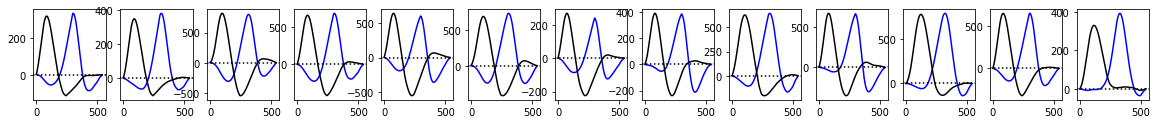

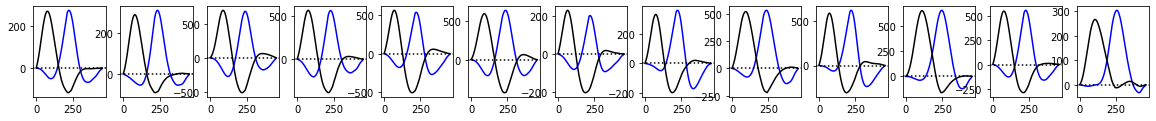

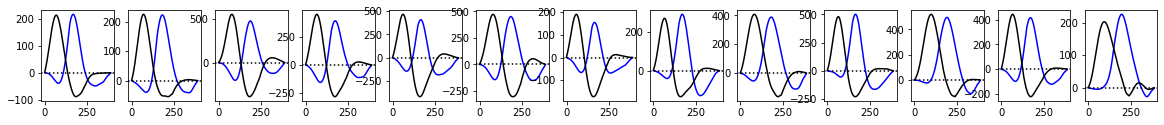

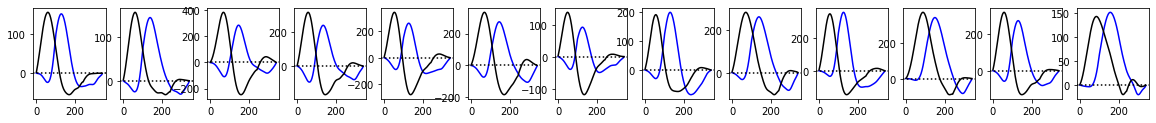

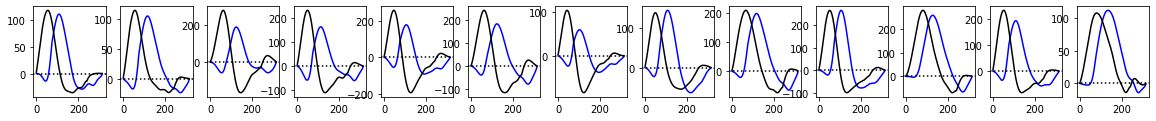

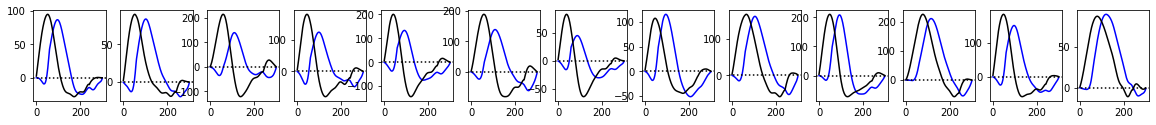

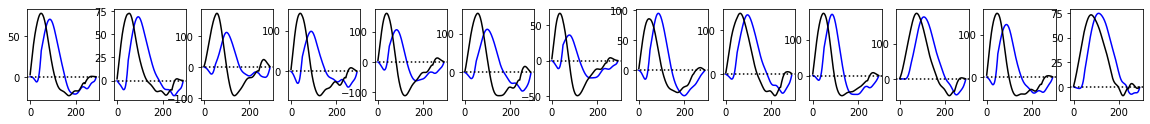

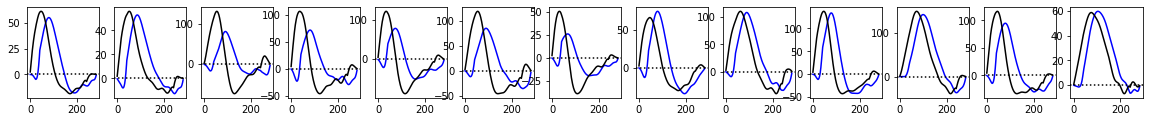

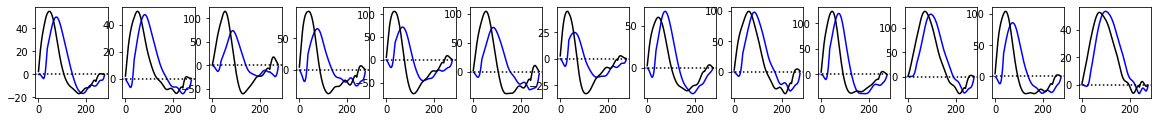

In [47]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis(velocity, convolution_params)
    dsi_all_all[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [48]:
def convolved_dsis_centered(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 260
    convolution_params['distance_covered'] = 260
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        spline = average_filters[:,13:26,clust]
        edge_buffer = 15 
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'full'#(ConvolutionKernelParams() & key).fetch1('kernel_type')

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          4:11]
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
#             print(kernel_length)
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#         if velocity == 1000:
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Convolved_responses_1000.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

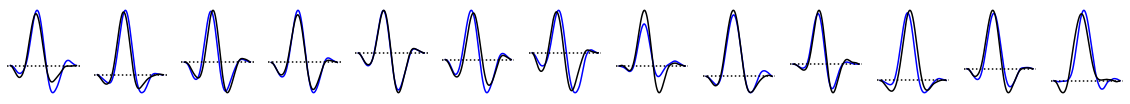

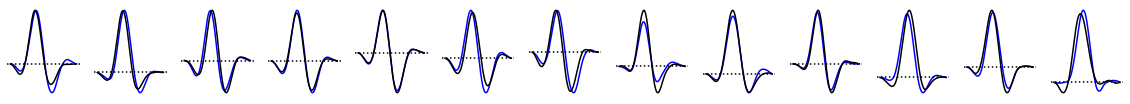

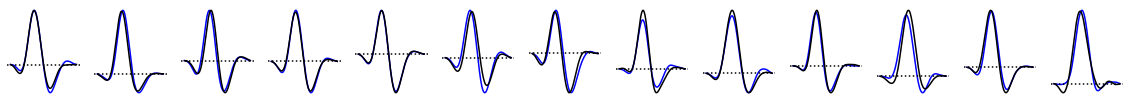

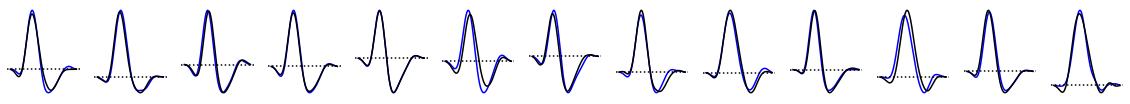

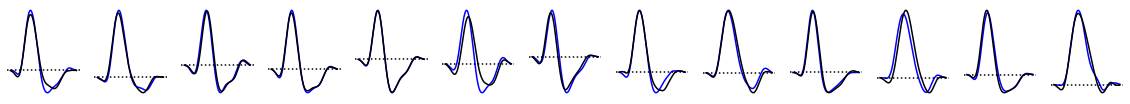

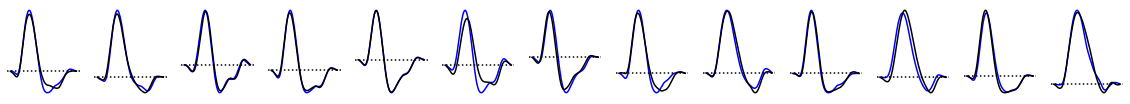

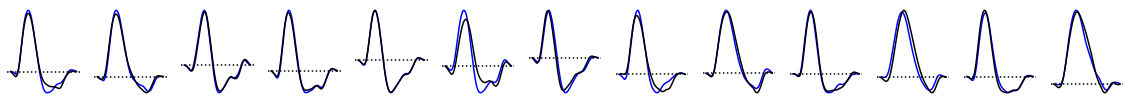

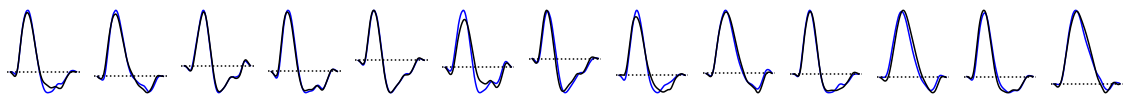

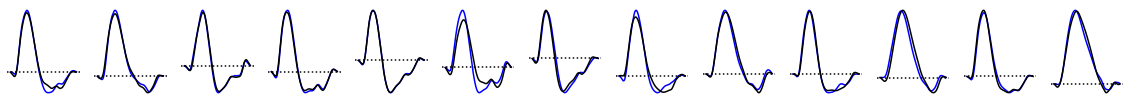

In [49]:
# run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered(velocity, convolution_params)
    dsi_all_all_centered[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

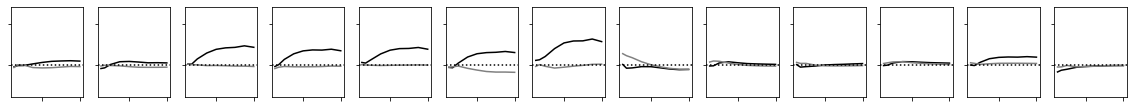

In [50]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered[:, clust]*-1, color='grey')
    ax[i].set_ylim([-.4, .72])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_both.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()

In [51]:
def convolved_dsis_drug(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 140
    convolution_params['distance_covered'] = 140
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries
        spline = average_filters_drug[:,:,clust] #average_filters_mirror[:, :, clust] 4:24
        edge_buffer = 15 #
        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'left'#

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
#         print(peak_y)
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(np.floor(peak_y - kernel_length / 2)):np.int(np.floor(peak_y + kernel_length / 2))]
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
    #     ax[i].set_yticklabels([])
    #     ax[i].set_xticklabels([])
    #     ax[i].axis('off')

    # Figpath = 'Fig_temp/'
    # savename = Figpath+"Convolved_responses.pdf"
    # plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

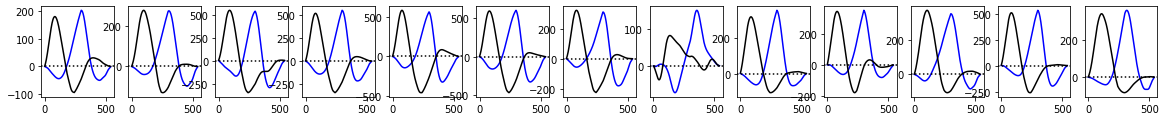

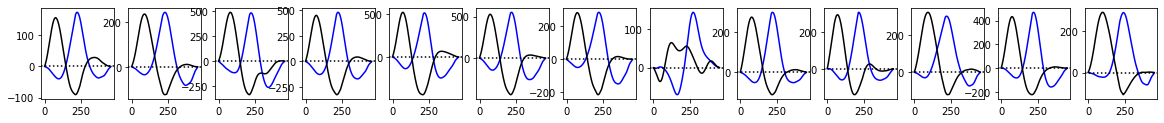

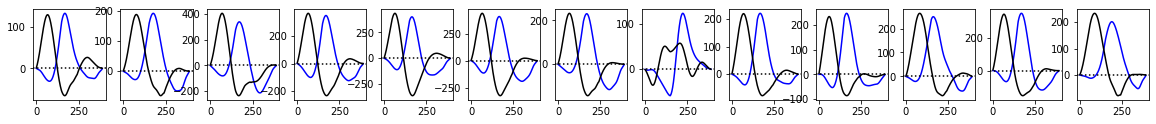

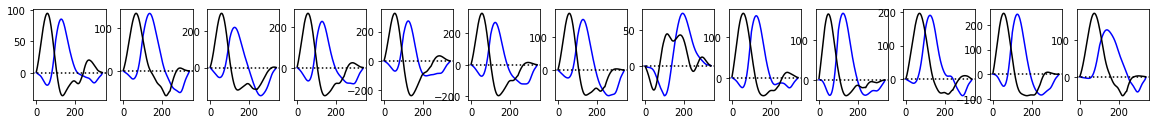

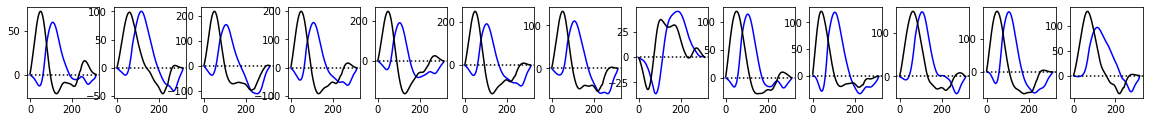

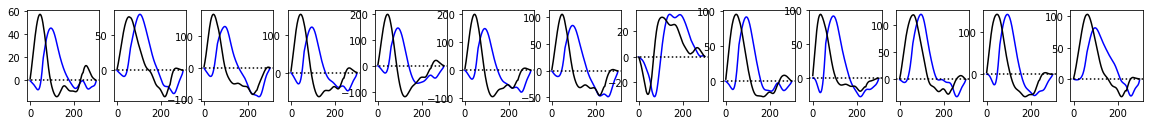

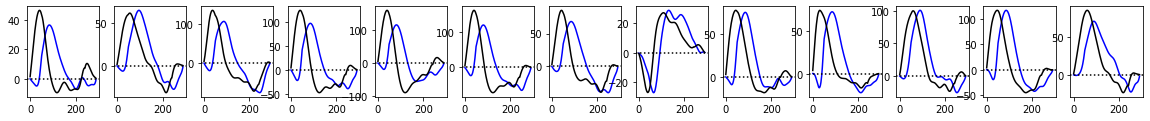

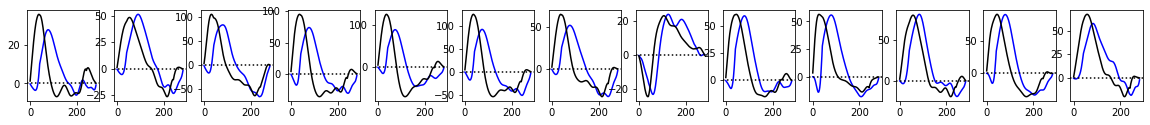

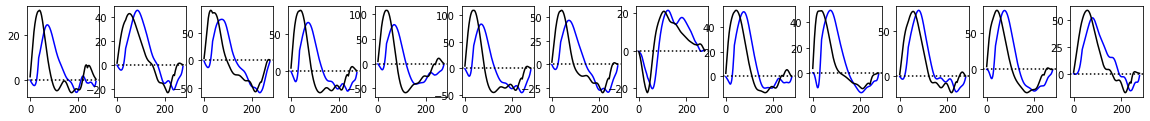

In [52]:
#run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_drug = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_drug(velocity, convolution_params)
    dsi_all_all_drug[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

In [53]:
def convolved_dsis_centered_drug(velocity, convolution_params):
    # velocity tuning

    # get the stimulus for convolution

    convolution_params['stimulus_velocity'] = velocity # WARNING altering this to play around with velocity tuning
    convolution_params['dendrite_length'] = 260
    convolution_params['distance_covered'] = 260
    if space_per_pixelx < space_per_pixely:  # check which is the shorter dimension of the stimulus
        space_per_pixel = space_per_pixelx
    else:
        space_per_pixel = space_per_pixely

    time, dend, diag, x_start, x_stop, y_start, y_stop = get_svg_parameters_on_screen(
        convolution_params['dendrite_length'],
        convolution_params['moving_bar_length'],
        convolution_params['stimulus_velocity'],
        convolution_params['starting_point'],
        convolution_params['distance_covered'],
        real_time_lag,
        time_points,
        space_per_pixel
    )

    string_svg = """<svg width="{0}" height="{1}" viewBox="0 0 {2} {3}">
        <rect x="0" y="0" width="{4}" height="{5}" fill="black" />
          <line x1="{6}" y1="{7}" x2="{8}" y2="{9}"
              stroke-width="{10}" stroke="white" stroke-linecap="square"/>
        </svg>""".format(dend, time, dend, time, dend, time, x_start, y_start, x_stop, y_stop, diag)

    folder_str = 'Data/'
    file_name = str(1)
    name_svg = folder_str + file_name + ".svg"
    name_png = folder_str + file_name + ".png"

    new_file = open(name_svg, "wt")
    new_file.write(string_svg)
    new_file.close()

    cairosvg.svg2png(url=name_svg, write_to=name_png)

    stimulus_image = np.array(Image.open(name_png).convert('L'))


    #get convolved responses

#     cluster_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,]
    dsi = np.zeros(13)
    dsi_off = np.zeros(13)

    fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
    for i, clust in enumerate(ipl_depth_order):
        # get the necessaries

        spline = average_filters_drug[:,13:26,clust]
        edge_buffer = 15 

        stimulus_image_rev = np.flip(stimulus_image, axis=0)
        kernel_type = 'full'

        # set up and crop the kernel
        kernel_length = stimulus_image.shape[1]  # needs to be the same length as the stimulus

        # get the location of the RF center in the kernel
        spline_temp = spline[edge_buffer:-edge_buffer, :]
        index_max = np.unravel_index(np.argmax(np.abs(spline_temp), axis=None), spline_temp.shape)
        peak_y = index_max[1]
        peak_y = 19

        # crop the kernel depending on the type of experiment
        if kernel_type == 'right':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y - 1):np.int(peak_y + kernel_length - 1)]
        elif kernel_type == 'left':
            spline_cut = spline[edge_buffer:-edge_buffer, np.int(peak_y + 1 - kernel_length):np.int(peak_y + 1)]
        elif kernel_type == 'full':
            spline_cut = spline[edge_buffer:-edge_buffer,
                         0:kernel_length]  # should be full kernel, just adding space range just in case
        elif kernel_type == 'centered':
#             spline_cut = spline[edge_buffer:-edge_buffer,
#                          4:11]
            spline_cut = spline[edge_buffer:-edge_buffer,
                         np.int(peak_y - (kernel_length-1) / 2):np.int(peak_y + (kernel_length-1) / 2 +1)]
#             print(kernel_length)
        else:
            spline_cut = spline  # just to make the code happy, this should never be the option
        # can code in other possibilities here...

        # check whether cut spline is big enough
        space_length = spline_cut.shape[1]
        if kernel_length == space_length:
            empty_flag = 0
            # setup output variables
            convolved_response = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))
            convolved_response_rev = np.zeros((spline_cut.shape[0] + stimulus_image.shape[0] - 1, spline_cut.shape[1]))

            # loop through x positions and convolve
            for x_position in range(stimulus_image.shape[1]):
                ker = np.flip(spline_cut[:, x_position])
                img = stimulus_image[:, x_position]
                img2 = stimulus_image_rev[:, x_position]
                # and then convolve these two
                convolved_response[:, x_position] = np.convolve(a=img, v=ker, mode='full')
                convolved_response_rev[:, x_position] = np.convolve(a=img2, v=ker, mode='full')
        else:
            empty_flag = 1
            convolved_response = []
            convolved_response_rev = []

        response = np.sum(convolved_response, axis=1)
        response_rev = np.sum(convolved_response_rev, axis=1)
        max_response = np.amax(response)
        max_response_rev = np.amax(response_rev)
        max_response_off = np.amin(response)
        max_response_rev_off = np.amin(response_rev)
        dsi[clust] = (max_response - max_response_rev) / (max_response + max_response_rev)
#         print(max_response, max_response_rev)
        dsi_off[clust] = (max_response_off - max_response_rev_off) / (max_response_off + max_response_rev_off)
#         dsi_all = np.where(cluster_avg_depth<0.5, dsi, dsi_off)
    #     print(dsi, dsi_off)
    #     plt.figure()
        ax[i].plot(response*polarity[clust], color='b')
        ax[i].plot(response_rev*polarity[clust], color='k')
        ax[i].axhline(color='k', linestyle='dotted')
        ax[i].set_yticklabels([])
        ax[i].set_xticklabels([])
        ax[i].axis('off')
#         if velocity == 1000:
#             Figpath = 'Fig_temp/'
#             savename = Figpath+"Convolved_responses_1000.pdf"
#             plt.savefig(savename, transparent=True, bbox_inches='tight')
    return dsi, dsi_off

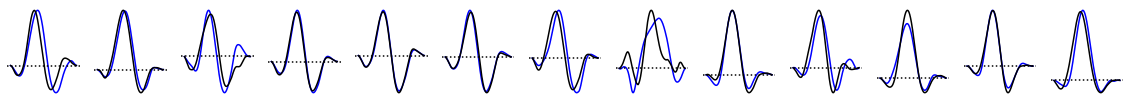

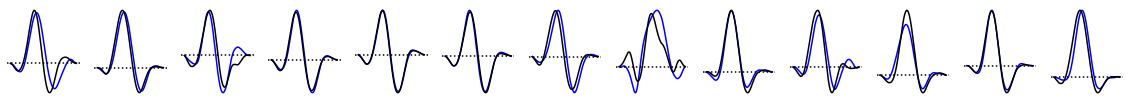

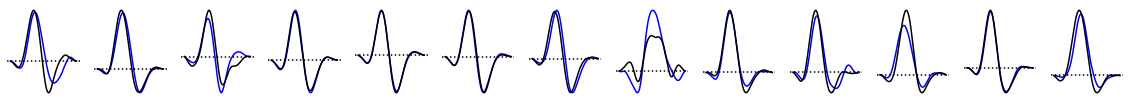

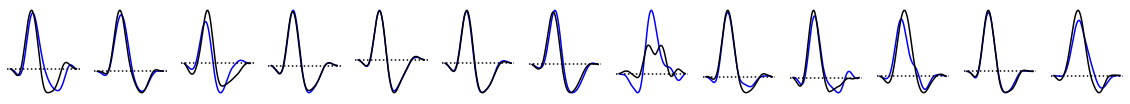

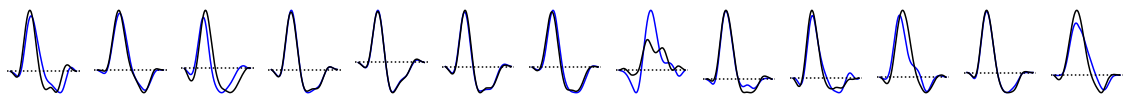

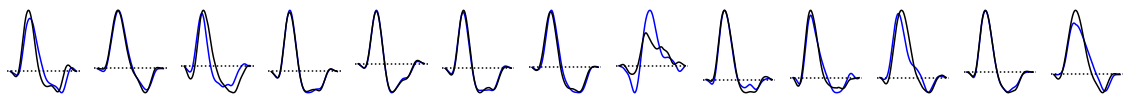

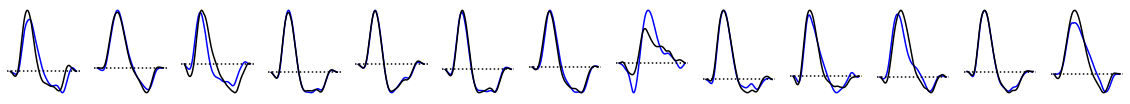

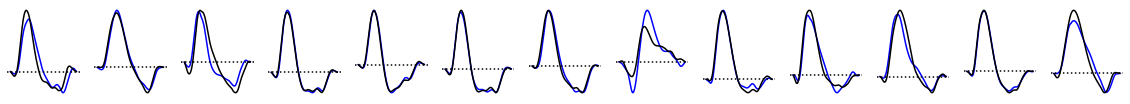

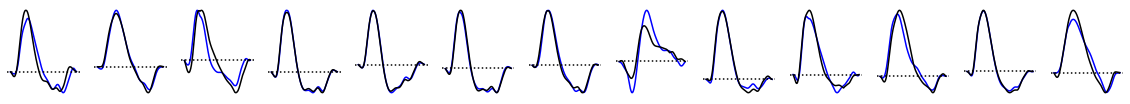

In [54]:
# run models
velocities = [250, 350, 500, 750, 1000, 1250, 1500, 1750, 2000]

dsi_all_all_centered_drug = np.zeros((len(velocities), 13))

for i, velocity in enumerate(velocities):
    dsi, dsi_off = convolved_dsis_centered_drug(velocity, convolution_params)
    dsi_all_all_centered_drug[i, :] = np.where(cluster_avg_depth<0.5, dsi, dsi_off)

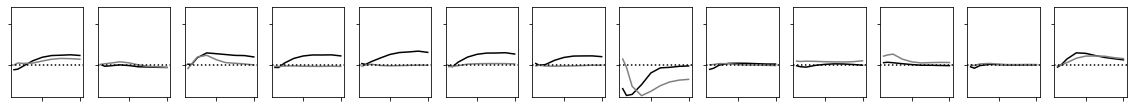

In [55]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all_drug[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered_drug[:, clust]*-1, color='grey')
    ax[i].set_ylim([-.4, .72])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_both.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()

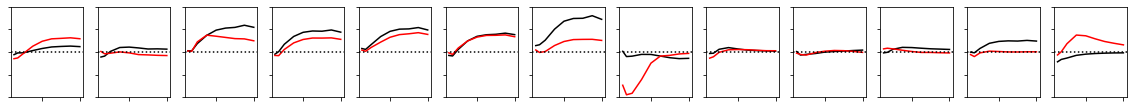

In [56]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_drug[:, clust]*-1, color='r')
    ax[i].set_ylim([-.4, .4])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_both.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()

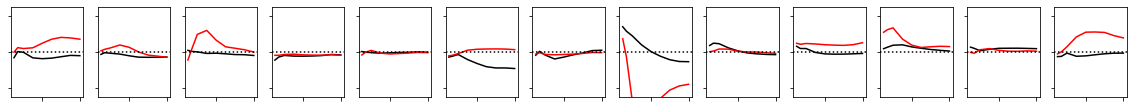

In [57]:
#DSI as a function of velocity for each stimulus case
fig, ax = plt.subplots(1, 13, figsize=(20, 1.6666))
for i, clust in enumerate(ipl_depth_order):

    ax[i].plot(velocities, dsi_all_all_centered[:, clust]*-1, color='k')
    ax[i].plot(velocities, dsi_all_all_centered_drug[:, clust]*-1, color='r')
    ax[i].set_ylim([-.25, .25])
    ax[i].axhline(color='k', linestyle='dotted')
    ax[i].set_yticklabels([])
    ax[i].set_xticklabels([])
#     ax[i].axis('off')
# plt.legend()


# Figpath = 'Fig_temp/'
# savename = Figpath+"Velocity_tuning_clusters_both.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')
plt.show()

# Motion responses by cluster

In [58]:
#pull these from hdf5
dsi_results_44 = pd.read_hdf('Data/FigS08.hdf5', 'dsi_results_44')
dsi_results_55 = pd.read_hdf('Data/FigS08.hdf5', 'dsi_results_55')

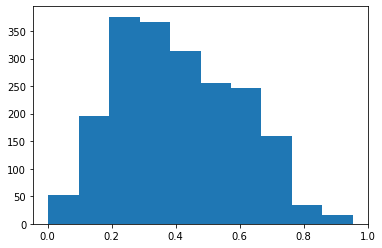

In [59]:
dsi_results_all = pd.concat([dsi_results_44, dsi_results_55])

plt.hist(dsi_results_all['mu_std_max'])

plt.show()

#remove non-responsive pixels, where the model failed to detect a large change in response
threshold = 0.1
dsi_results_all = dsi_results_all[dsi_results_all['mu_std_max']>threshold]
dsi_results_all.pop('mu_std_max')

std_100 = dsi_results_all['dsi_100'].std()
std_150 = dsi_results_all['dsi_150'].std()
std_200 = dsi_results_all['dsi_200'].std()
std_300 = dsi_results_all['dsi_300'].std()
std_100d = dsi_results_all['dsi_100d'].std()
std_150d = dsi_results_all['dsi_150d'].std()
std_200d = dsi_results_all['dsi_200d'].std()
std_300d = dsi_results_all['dsi_300d'].std()

mean_dsi = dsi_results_all['d_prime'].mean()
dsi_results_all['dsi_diff'] = dsi_results_all['dsi_100d']*-1 - dsi_results_all['dsi_100']*-1

std_dsi = np.array([std_100, std_150, std_200, std_300])
std_dsi_d = np.array([std_100d, std_150d, std_200d, std_300d])

std_top = mean_dsi + std_dsi
std_bottom = mean_dsi - std_dsi

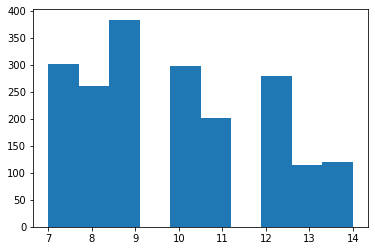

In [60]:
plt.hist(dsi_results_all['cluster_center'])

plt.show()

In [61]:
for_boxplot = pd.melt(dsi_results_all[dsi_results_all['cluster_center'].isin(
    [9,10])].reset_index(), id_vars=['index', 'cluster_assignment', 'field'],
                      value_vars=['dsi_100', 'dsi_100d'])

In [62]:
for_boxplot['value']=for_boxplot['value']*-1

In [63]:
ipl_depth_order_on = [0,  3,  9,  7, 11,  2,  8]#,  5]

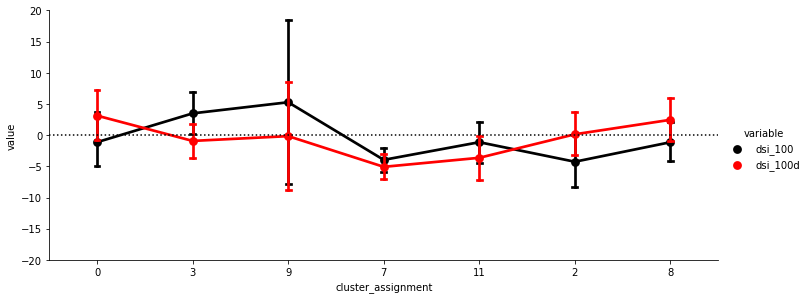

In [64]:
# fig = plt.figure(figsize=(10,5))
sns.catplot(x="cluster_assignment", y="value", hue="variable",order=ipl_depth_order_on, data=for_boxplot,
                capsize=.05, palette=['k','red'],  markersize=2,linewidth=1,height=4, aspect=10/4,
                kind="point", ci=95,
               
               )

axes = plt.gca()

axes.axhline(linestyle='dotted', color='k')
axes.set_ylim([-20,20])



# Figpath = 'Fig_temp/'
# savename = Figpath+"Motion_responses_control_Strych_CI95.pdf"
# plt.savefig(savename, transparent=True, bbox_inches='tight')

plt.show()

In [65]:
# stats: 2-way repeated measures Anova
import pingouin as pg
#need to remove the off clusters for testing
for_stats = for_boxplot[for_boxplot['cluster_assignment'].isin(ipl_depth_order_on)]
for_stats["id"] = for_stats['index']+for_stats["field"]*10000
pg.rm_anova(dv='value',
                  within=['cluster_assignment', 'variable'],
                  subject='id', data=for_stats, correction=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/gpfs01/euler/User/avlasits/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:38

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,cluster_assignment,50669.842054,6,2742,8444.973676,-38.947430,1.000000,NaN,-0.093164,NaN
1,variable,82.287679,1,457,82.287679,0.066932,0.795974,0.795974,0.000146,1.0
2,cluster_assignment * variable,24412.281346,6,2742,4068.713558,-22.045273,1.000000,NaN,-0.050684,NaN


In [66]:
pg.pairwise_ttests(dv='value', within='cluster_assignment', subject='id',
                              between='variable', padjust='bonf', data=for_stats)

ValueError: Repeated measures dataframe is not balanced. `Subjects` must have the same number of elements in all conditions, even when missing values are present.